# Build a Convolutional Neural Network (CNN) model to classify images from a given dataset into predefined categories/classes.

3/4 final layers max
optimizer= adam could be ok
number of filters

### Importing general dependencies

In [99]:
#Import general dependencies

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, AveragePooling2D, Input, Add, Flatten, Dropout, MaxPool2D, MaxPooling2D
from keras.initializers import glorot_uniform as gu
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing import image
from keras.utils import image_dataset_from_directory


!git clone https://github.com/sofzcc/project-1-deep-learning-image-classification-with-cnn/


fatal: destination path 'project-1-deep-learning-image-classification-with-cnn' already exists and is not an empty directory.


### Data Loading


In [100]:
!kaggle datasets download -d alessiocorrado99/animals10 -p /content

import zipfile
import os

# Define the path to the zip file
zip_file_path = '/content/animals10.zip'

# Define the directory where you want to extract the files
extract_dir = '/content/animals10/'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


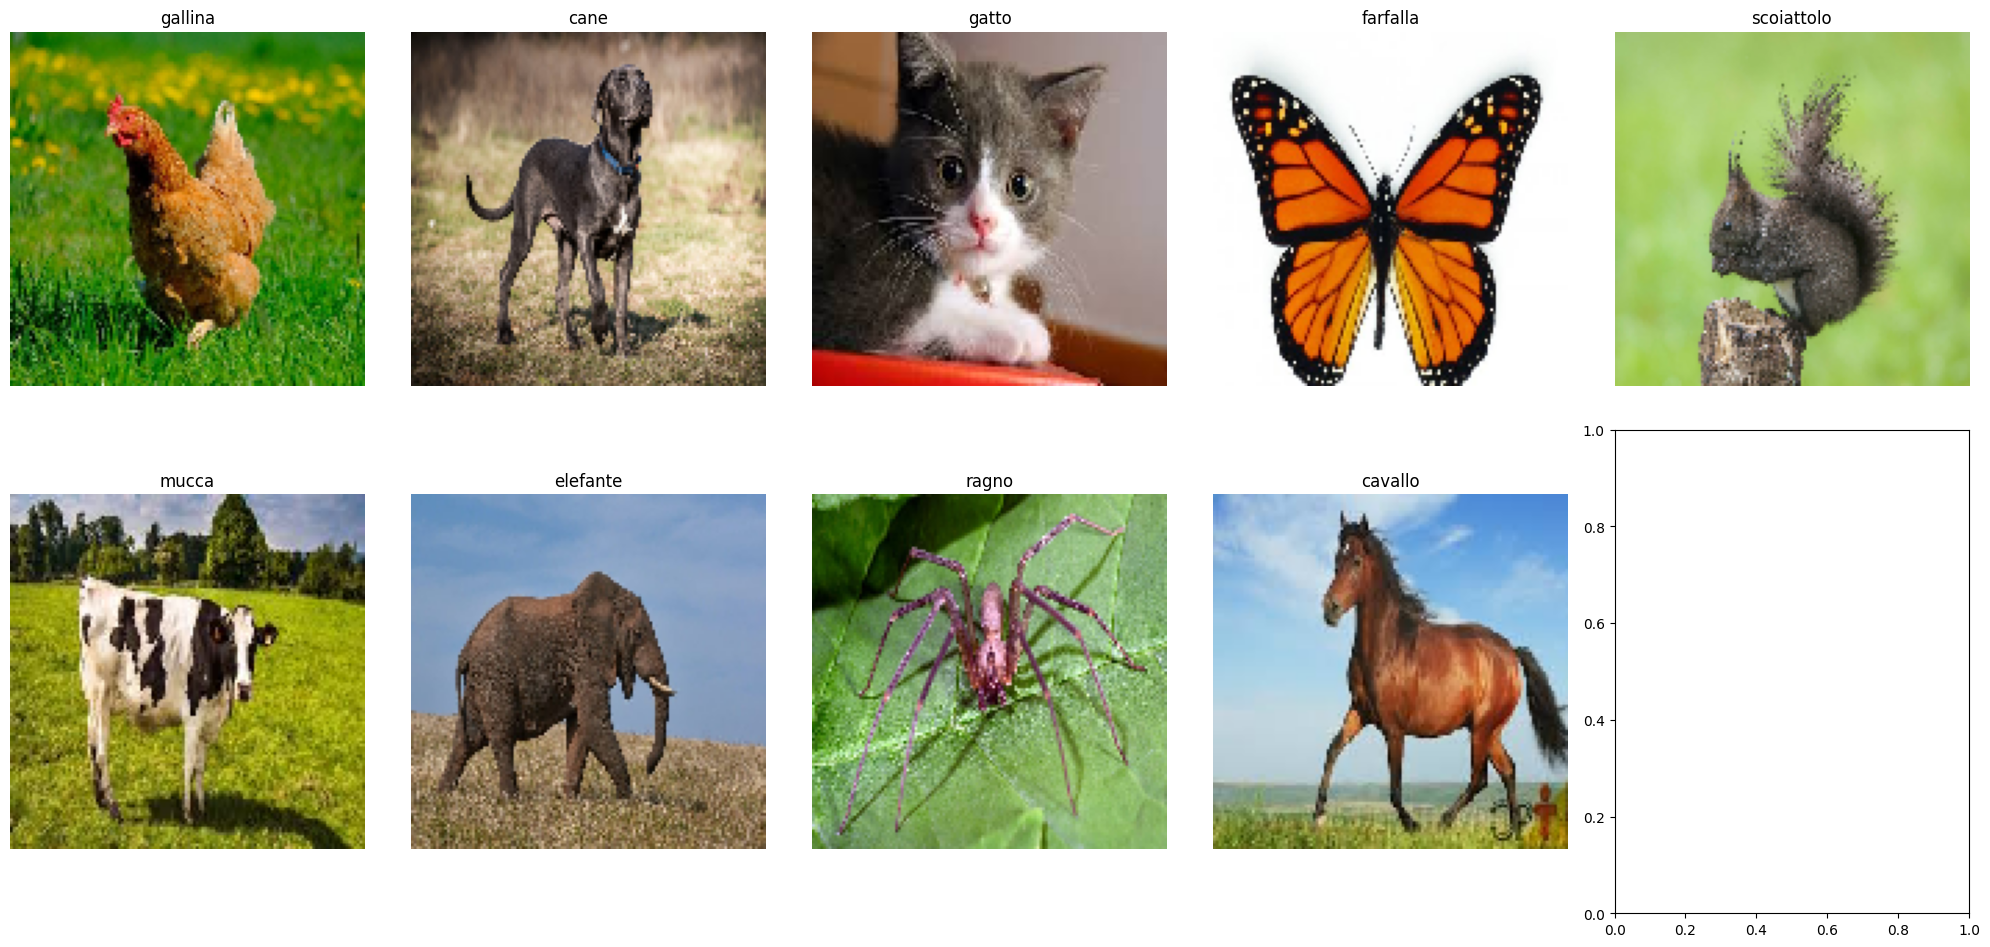

In [101]:
from PIL import Image

#Load into a dataset

animals_dir = '/content/animals10/raw-img'

#Create test dataset
test_folder_path = '/content/project-1-deep-learning-image-classification-with-cnn/test'

test_images = []
test_class_names = []

for folder in os.listdir(test_folder_path):
    folder_path = os.path.join(test_folder_path, folder)
    if os.path.isdir(folder_path):  # Ensure it's a directory
        for filename in os.listdir(folder_path):
            if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
                img_path = os.path.join(folder_path, filename)
                img = Image.open(img_path)
                test_images.append(np.array(img))
                test_class_names.append(folder)

#Plotting the images from each class in the test set
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
axes = axes.flatten()
for ax, class_name in zip(axes, test_class_names):
    class_dir = os.path.join(test_folder_path, class_name)
    file_list = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    if file_list:
      path_sample = os.path.join(class_dir, file_list[0])  # Selecting the first file
      img = image.load_img(path_sample, target_size=(128, 128))
      ax.imshow(img)
      ax.set_title(class_name)
      ax.axis('off')
    else:
      print(f"Class {class_name} has no valid images.")
      continue
plt.tight_layout()
plt.show()

#Data Exploration

Explore the Dataset: Get an overview of the data, including the number of classes, number of images per class, and sample images.


In [102]:
# List all classes
print("This dataset contains the following classes:")
class_names = []
for class_name in os.listdir(animals_dir):
    class_names.append(class_name)
    print(f"{class_name}")

# Counting total images per class
image_class = {}
for class_name in class_names:
    class_dir = os.path.join(animals_dir, class_name)
    image_class[class_name] = len(os.listdir(class_dir))

print("\n\nTotal images per class:")
for class_name, count in image_class.items():
    print(f"{class_name} : {count}")

This dataset contains the following classes:
pecora
gallina
cane
gatto
farfalla
scoiattolo
mucca
elefante
ragno
cavallo


Total images per class:
pecora : 1820
gallina : 3098
cane : 4863
gatto : 1668
farfalla : 2112
scoiattolo : 1862
mucca : 1866
elefante : 1446
ragno : 4821
cavallo : 2623


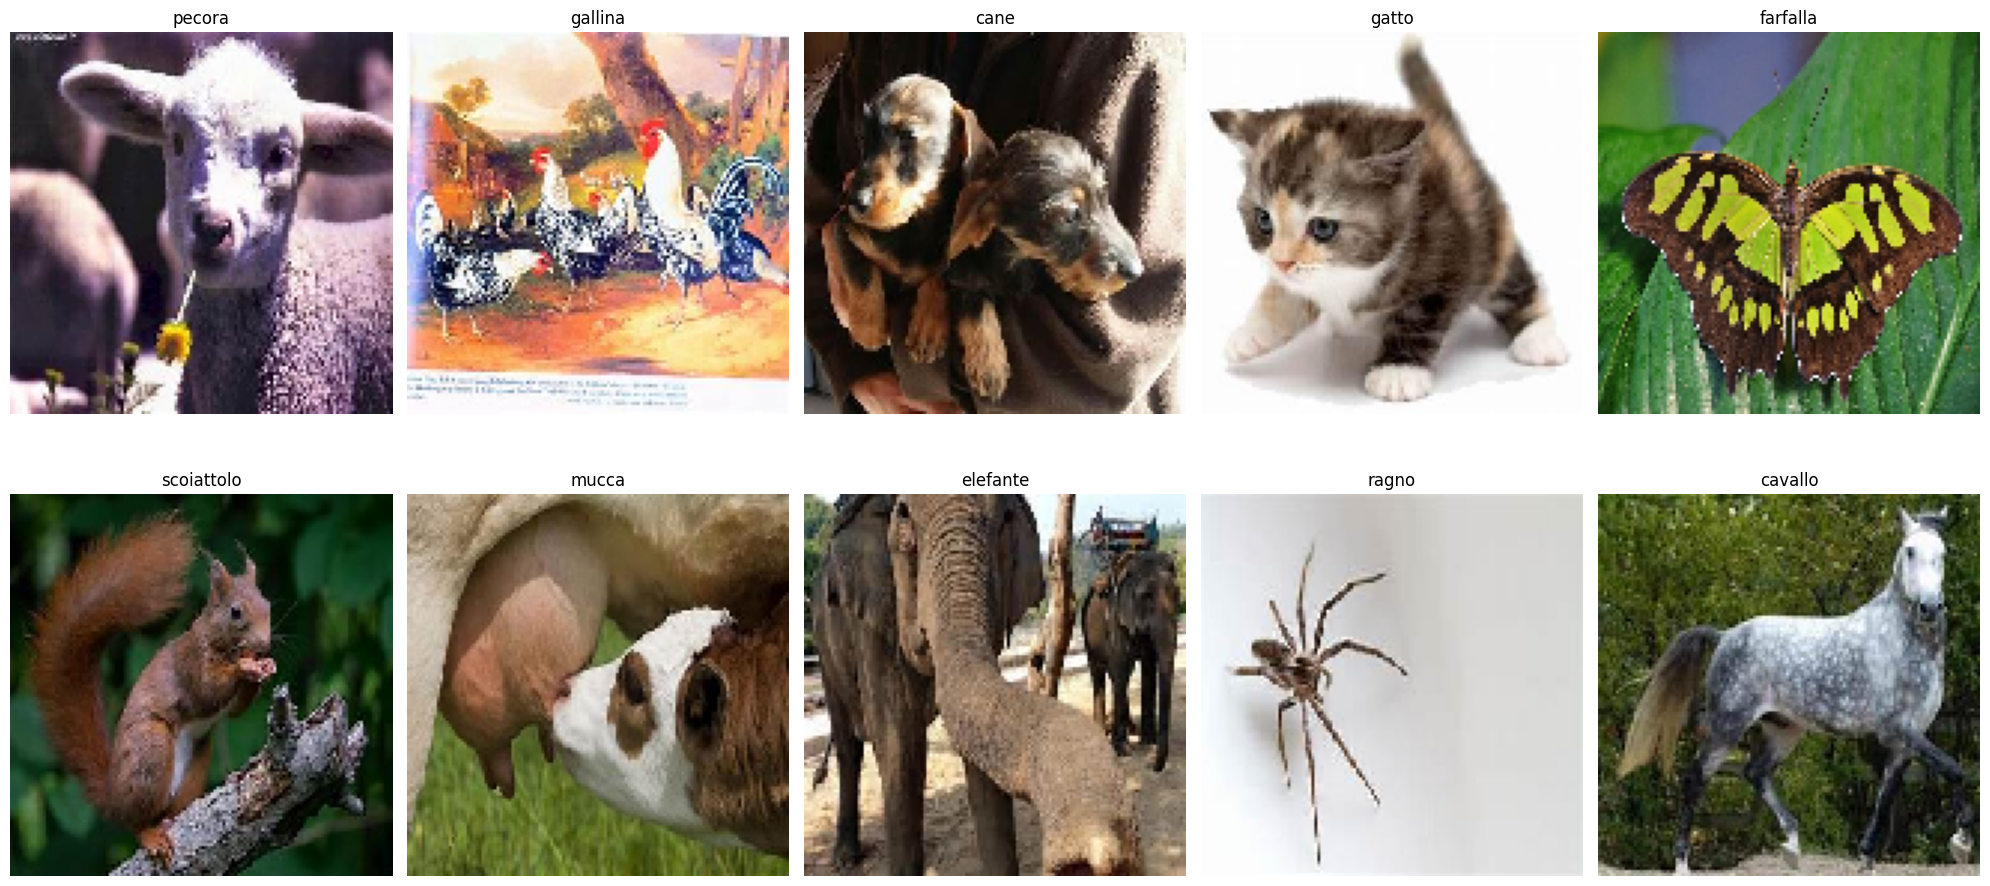

In [103]:
#Plotting sample images from each class
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
axes = axes.flatten()
for ax, class_name in zip(axes, class_names):
    class_dir = os.path.join(animals_dir, class_name)
    file_list = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    if file_list:
      path_sample = os.path.join(class_dir, file_list[0])  # Selecting the first file
      img = image.load_img(path_sample, target_size=(128, 128))
      ax.imshow(img)
      ax.set_title(class_name)
      ax.axis('off')
    else:
      continue
plt.tight_layout()
plt.show()

### Data Preprocessing

Preprocessing (e.g., normalization, resizing, augmentation).
Create visualizations of some images, and labels.


In [104]:
from keras.preprocessing.image import ImageDataGenerator


data_generator = ImageDataGenerator(
    rescale=1./255.0, #normalizes pixel values from 0-255 to 0-1
    horizontal_flip=True, #randomly flips images horizontally
    zoom_range=0.2,         # Zoom in on the image by a maximum of 20%
    width_shift_range=0.2,  # Shift the image horizontally by a maximum of 20% of the width
    height_shift_range=0.2, # Shift the image vertically by a maximum of 20% of the height
    shear_range=0.2,        # Shear the image by a maximum of 20%
    brightness_range=[0.5, 1.5],
    validation_split=0.2,
    fill_mode="nearest") #splits the data into train and validation sets



#Split into train and test sets

train_set = data_generator.flow_from_directory(
    animals_dir,
    target_size=(128,128),
    batch_size = 64,
    class_mode="sparse",
    subset="training"
)

validation_set = data_generator.flow_from_directory(
    animals_dir,
    target_size=(128,128),
    batch_size = 64,
    class_mode="sparse",
    subset="validation"
)
test_data_generator = ImageDataGenerator(rescale= 1./255.0)
test_set = test_data_generator.flow_from_directory(
    test_folder_path,
    target_size=(128,128),
    batch_size = 64,
    class_mode='sparse'
)



Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.
Found 9 images belonging to 10 classes.


## Model Architecture

Design a CNN architecture suitable for image classification.
Include convolutional layers, pooling layers, and fully connected layers.


In [105]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2



cnn_model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(class_names), activation="softmax"),
]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])



early_stopping = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)



In [106]:
print(len(train_set))

cnn_model.summary()


328
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_71 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_72 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                 

##Model Training

Train the CNN model using appropriate optimization techniques (e.g., stochastic gradient descent, Adam).
Utilize techniques such as early stopping to prevent overfitting.


In [ ]:
history = cnn_model.fit(train_set, validation_data=validation_set, epochs=50, callbacks=[early_stopping, reduce_lr], verbose=2)

Epoch 1/50
328/328 - 139s - loss: 2.1308 - accuracy: 0.2681 - val_loss: 3.3880 - val_accuracy: 0.2154 - lr: 1.0000e-04 - 139s/epoch - 423ms/step
Epoch 2/50


## Model Evaluation

Evaluate the trained model on a separate validation set.
Compute and report metrics such as accuracy, precision, recall, and F1-score.
Visualize the confusion matrix to understand model performance across different classes

In [ ]:
test_loss, test_acc = cnn_model.evaluate(test_set, test_class_names)
print(f"Test accuracy: {test_acc}")

## Transfer Learning

Evaluate the accuracy of your model on a pre-trained models like ImagNet, VGG16, Inception... (pick one an justify your choice)
Perform transfer learning with your chosen pre-trained models i.e., you will probably try a few and choose the best one.

### Removing the first layer and performing transfer learning using pre-trained models

### Removing the first layer and performing transfer learning using pre-trained models